In [32]:
import matplotlib.pyplot as plt
import pandas as pd

import modin.pandas as md

import pandasql as pdsql
import seaborn as sns
import numpy as np
import io
import json

**Всего 1311 разных диспетчерских служб** - максимум записей для одной - 20766, минимум - 1; максимальный промежуток времени - 284 дня

**Получаю по одной компании список из словарей**
```
[
   {"serving_company": компания 1, "grades_for_service": None, "dates_of_review":None},
   {"serving_company": компания 1, "grades_for_service": "Хорошо", "dates_of_review":дата2},
   {"serving_company": компания 1, "grades_for_service": "Отлично", "dates_of_review":дата3}
]
```

In [33]:
path = "../Full_16_09_22.csv"

naming_path = "../naming.csv"

In [34]:
naming = pd.read_csv(naming_path)

In [35]:
columns = [
    "root_id", "dispetchers_number", "efficiency", "closure_date", "date_of_review", "grade_for_service"
]

russian_columns = list(naming.loc[naming["new_name"].isin(columns), "old_name"])

In [36]:
df = pd.DataFrame(
    md.read_csv(
        path,
        nrows=int(6e6),
        sep="$",
        usecols=russian_columns
    )
).set_axis(columns, axis=1).astype({
    "date_of_review": "datetime64",
    "closure_date": "datetime64",
    "root_id": str
})

In [37]:
test_list = df[df["dispetchers_number"] == "ОДС №1-Рязанский"].to_dict("records")   # формат по которому строить графики

In [38]:
len(test_list)

18541

---
Plotting:

In [39]:
test_list

[{'root_id': '73407495',
  'dispetchers_number': 'ОДС №1-Рязанский',
  'efficiency': 'Не выполнено по инициативе УК/ОО',
  'closure_date': Timestamp('2021-01-01 05:00:53.312520'),
  'date_of_review': NaT,
  'grade_for_service': nan},
 {'root_id': '73413064',
  'dispetchers_number': 'ОДС №1-Рязанский',
  'efficiency': 'Выполнено',
  'closure_date': Timestamp('2021-01-01 08:13:30.625288'),
  'date_of_review': Timestamp('2021-04-15 22:43:28.840557'),
  'grade_for_service': 'Удовлетворительно'},
 {'root_id': '73417181',
  'dispetchers_number': 'ОДС №1-Рязанский',
  'efficiency': 'Оказана консультация',
  'closure_date': Timestamp('2021-01-01 09:24:18.495832'),
  'date_of_review': NaT,
  'grade_for_service': nan},
 {'root_id': '73418576',
  'dispetchers_number': 'ОДС №1-Рязанский',
  'efficiency': 'Оказана консультация',
  'closure_date': Timestamp('2021-01-01 09:36:39.981500'),
  'date_of_review': NaT,
  'grade_for_service': nan},
 {'root_id': '73420304',
  'dispetchers_number': 'ОДС №1-Ря

даты, в которые понизилась средняя оценка и повысилась эффективность делим на даты, в которые понизилась оценка

In [40]:
class Plotter:
    def __init__(self) -> None:
        self.red = "red"
        self.green = "#19563A"
        self.axis_color = "#CCCCCC"
        self.red_scatter = "#F0695E"
        self.green_scatter = "#497963"
        self.grades_to_numbers = {"Отлично": 5, "Хорошо": 4, "Удовлетворительно": 3, "Плохо": 2, "Неудовлетворительно": 1}

    def plot_ascending_eff(self, x, y):
        '''
        returns: list of dates that 

        x is always ascending
        '''
        plotted = 0
        dates_ascending_eff = []

        for i in range(1, len(y)):
            if y[i] > y[i - 1]:
                dates_ascending_eff.append(x[i - 1])
                if plotted == 0:
                    plt.plot([x[i - 1], x[i]], [y[i - 1], y[i]], color=self.green, label="Положительная динамика результативности")
                    plotted += 1
                else:
                    plt.plot([x[i - 1], x[i]], [y[i - 1], y[i]], color=self.green)
        return dates_ascending_eff

    def color_dots(self, x, y):
        '''
        x - from 0 to 100
        '''
        plotted = 0
        dates_descending_grades = []

        for i in range(len(x)):
            if y[i] < 60:
                if plotted == 0:
                    plt.scatter(x[i], y[i], color=self.red_scatter, marker="x", s=150, label="Дни с низкой оценкой", linewidths=2)
                    plotted += 1
                else:
                    plt.scatter(x[i], y[i], color=self.red_scatter, marker="x", s=150, linewidths=2)

        for i in range(1, len(y)):
            if y[i] < y[i - 1]:
                dates_descending_grades.append(x[i - 1])

        return dates_descending_grades

    def svg_from_json(self, list_of_dicts, figsize_scale=1.5):
        '''
        input: list_of_dicts;
        output: svg string (or json with two svg strings - for each graph)
        '''
        figsize = (16 * figsize_scale, 9 * figsize_scale)

        df = pd.DataFrame(list_of_dicts).astype({"closure_date": "datetime64[D]"}).sort_values(by="closure_date").drop(columns=["dispetchers_number", "root_id"])
        df["closure_date"] = df["closure_date"].to_numpy(dtype="datetime64[D]")

        df_grades = df.loc[df["grade_for_service"].notna()]
        df_grades.index = [i for i in range(len(df_grades))]
        df_grades["grade_for_service"] = df_grades["grade_for_service"].replace(self.grades_to_numbers)
        dates_for_grades = df_grades["closure_date"].unique()

        if len(dates_for_grades) < 3:
            raise Exception("AMOUNT OF UNIQUE DATES IS BELOW 3")

        mean_grades = []
        for date in dates_for_grades:
            mean_grades.append(df_grades.loc[df_grades["closure_date"] == date]["grade_for_service"].mean())


        xticks_step = 1 + len(dates_for_grades) // 50

        # plotting:
        plt.figure(figsize=figsize)
        mean_grades = np.array(mean_grades) * 20
        
        plt.scatter(dates_for_grades, mean_grades, color=self.green_scatter, marker="x", s=100, label="Дни с высокой оценкой", linewidths=2)
        dates_descending_grades = self.color_dots(dates_for_grades, mean_grades)

        df_efficiency = df.loc[df["efficiency"].notna()]
        df_efficiency.index = [i for i in range(len(df_efficiency))]
        done_percent = []
        for date in dates_for_grades:
            done_percent.append(
            round(100 * len(df_efficiency.loc[(df_efficiency["closure_date"] == date) & (df_efficiency["efficiency"] == "Выполнено")]) / len(df_efficiency.loc[(df_efficiency["closure_date"] == date)]))
            )
        plt.plot(dates_for_grades, done_percent, color=self.red, label="Отрицательная динамика результативности")
        dates_ascending_eff = self.plot_ascending_eff(x=dates_for_grades, y=done_percent)

        if len(dates_descending_grades) != 0:
            k = 0
            for date in dates_ascending_eff:
                if date in dates_descending_grades:
                    k += 1
            interpretation_metric = k / (len(dates_descending_grades))
            if interpretation_metric >= 0.5:
                commentary = f"Анализ обратной связи сильно влияет на эффективность, коэффициент влияния: {interpretation_metric:.2f}"
            elif interpretation_metric >= 0.2:
                commentary = f"Анализ обратной связи средне влияет на эффективность, коэффициент влияния: {interpretation_metric:.2f}"
            else:
                commentary = f"Анализ обратной связи слабо влияет на эффективность, коэффициент влияния: {interpretation_metric:.2f}"
        else:
            commentary = "Средняя оценка не понижалась, сложно судить о влиянии анализа обратной связи на эффективность" 

        xticks = (dates_for_grades)[::xticks_step]
        plt.xticks(xticks, rotation=75, fontsize=8)
        plt.yticks(
            list(map(lambda x: x * 20, list(self.grades_to_numbers.values()))), list(self.grades_to_numbers.keys())
            )
        plt.ylabel("Оценка", fontsize=20, color=self.axis_color)

        plt.legend(loc="best", fontsize=12)
        plt.grid(alpha=0.3)
        ax = plt.gca()
        ax2 = ax.twinx()
        ax2.spines['bottom'].set_color('white')
        ax2.spines['top'].set_color('white')
        ax2.spines['right'].set_color('white')
        ax2.spines['left'].set_color('white')
        plt.ylabel("Результативность, %", fontsize=20, color=self.axis_color)
        plt.yticks([i for i in range(0, 110, 10)])

        plt.grid(alpha=0.3)

        f = io.StringIO()
        plt.savefig(f, format = "svg")
        plt.savefig("fig.svg", format="svg")


        return {
            "graph" : f.getvalue(),
            "commentary": commentary
        }

Надо скорее не на ухудшение оценок смотреть, а если в дату X - 1 у нас плохая оценка, а потом в дату X повысилась результативность, то все круто

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.44642857142857145


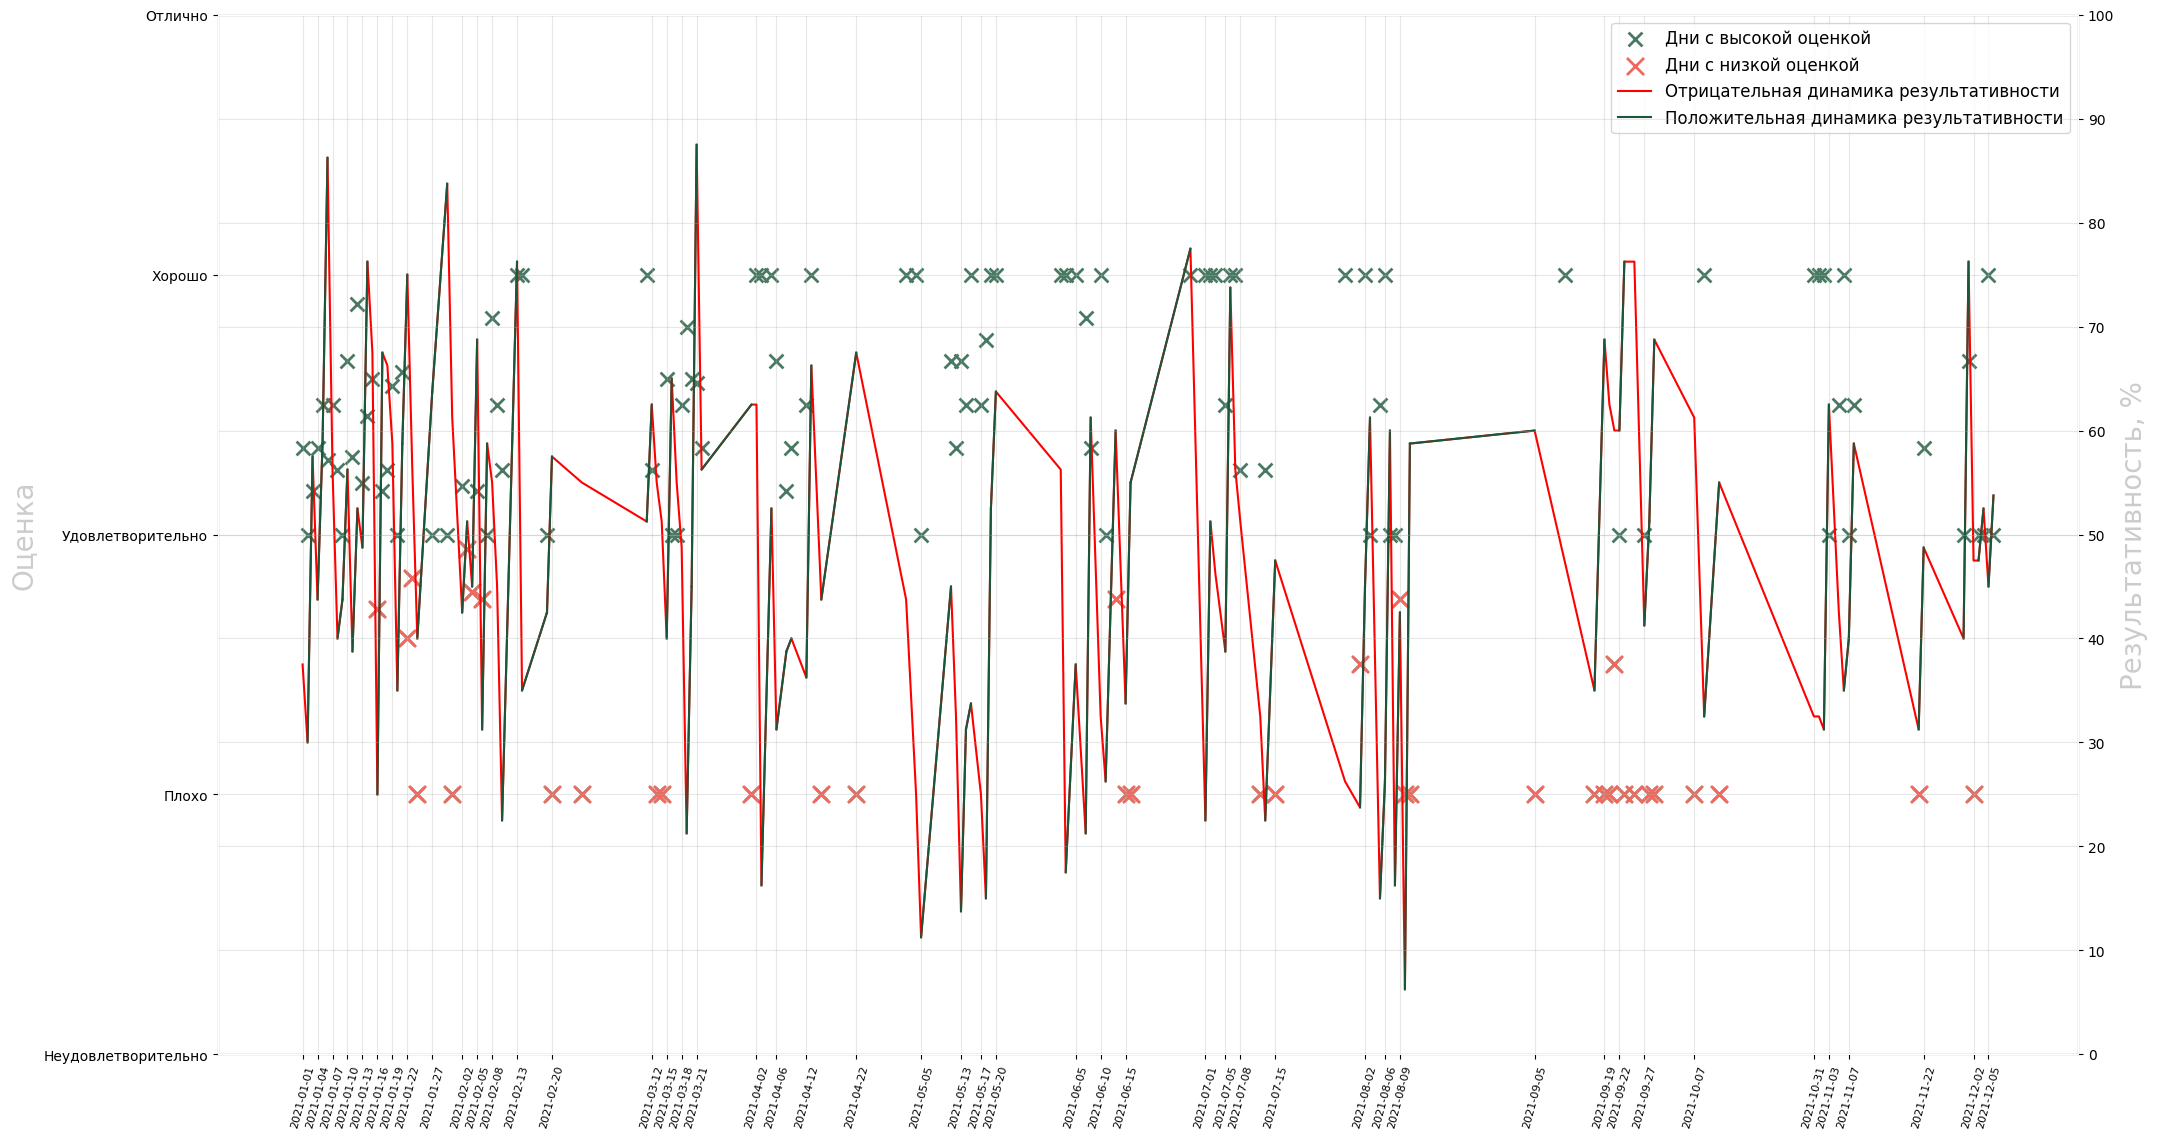

In [41]:
pl = Plotter()

line = pl.svg_from_json(
    test_list, figsize_scale=1.5
)